In [150]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [151]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size=(256,256),
)

Found 714 files belonging to 7 classes.


In [152]:
len(dataset)
train_size = 0.8 
len(dataset)*train_size , len(dataset)*0.2

(18.400000000000002, 4.6000000000000005)

In [153]:
train_ds = dataset.take(72)
len(train_ds)

23

In [154]:
test_ds = dataset.skip(72)
len(test_ds)

0

In [155]:
val_ds = test_ds.take(9)
test_ds = test_ds.skip(9)
len(test_ds) , len(val_ds)

(0, 0)

In [156]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [157]:

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
len(train_ds),len(test_ds),len(test_ds)


(18, 3, 3)

In [158]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [159]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [160]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [161]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [181]:
input_shape = (256, 256, 3)
n_classes = 7

model = keras.models.Sequential([
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu',),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [182]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [183]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


18/18 [==============================] - 7s 186ms/step - loss: 5.4334 - accuracy: 0.1570 - val_loss: 1.8641 - val_accuracy: 0.2969
Epoch 2/50
18/18 [==============================] - 3s 171ms/step - loss: 1.7953 - accuracy: 0.2708 - val_loss: 1.6245 - val_accuracy: 0.3281
Epoch 3/50
18/18 [==============================] - 3s 172ms/step - loss: 1.4586 - accuracy: 0.4206 - val_loss: 1.4498 - val_accuracy: 0.5000
Epoch 4/50
18/18 [==============================] - 3s 169ms/step - loss: 1.1871 - accuracy: 0.5289 - val_loss: 1.9391 - val_accuracy: 0.2656
Epoch 5/50
18/18 [==============================] - 3s 171ms/step - loss: 1.0289 - accuracy: 0.5722 - val_loss: 1.3507 - val_accuracy: 0.4844
Epoch 6/50
18/18 [==============================] - 3s 176ms/step - loss: 1.0908 - accuracy: 0.6137 - val_loss: 1.7694 - val_accuracy: 0.3750
Epoch 7/50
18/18 [==============================] - 3s 171ms/step - loss: 1.0855 - accuracy: 0.5903 - val_loss: 1.3832 - val_accuracy: 0.4844
Epoch 8/50
18/18 

In [184]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 0s 31ms/step - loss: 0.7229 - accuracy: 0.7396


In [185]:
class_names = dataset.class_names
class_names

['anthrecnose of pepper',
 'broad mites',
 'cercospora leaf spot of chilli',
 'chilli thrips',
 'healthy chilli',
 'leaf miner',
 'wilt']

1/1 [==============================] - 0s 35ms/step
actual label: healthy chilli
predicted label: broad mites
actual label: leaf miner
predicted label: leaf miner
actual label: chilli thrips
predicted label: healthy chilli
actual label: chilli thrips
predicted label: chilli thrips
actual label: chilli thrips
predicted label: healthy chilli
actual label: cercospora leaf spot of chilli
predicted label: cercospora leaf spot of chilli
actual label: wilt
predicted label: wilt
actual label: chilli thrips
predicted label: healthy chilli
actual label: anthrecnose of pepper
predicted label: healthy chilli
actual label: wilt
predicted label: wilt
actual label: wilt
predicted label: wilt
actual label: broad mites
predicted label: broad mites
actual label: cercospora leaf spot of chilli
predicted label: leaf miner
actual label: broad mites
predicted label: broad mites
actual label: chilli thrips
predicted label: chilli thrips
actual label: broad mites
predicted label: broad mites
actual label: cer

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 32 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

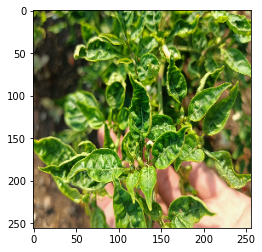

In [194]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    batch_prediction = model.predict(images_batch)
    for i in range(50):
        first_image = images_batch[i].numpy().astype('uint8')
        plt.imshow(first_image)
        first_label = labels_batch[i].numpy()
        print("actual label:",class_names[first_label])
        print("predicted label:",class_names[np.argmax(batch_prediction[i])])

In [191]:
import os
model.save(f"./models/")

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


In [177]:
model.save('chilli.pkl')

INFO:tensorflow:Assets written to: chilli.pkl\assets


INFO:tensorflow:Assets written to: chilli.pkl\assets
